In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import tensorflow as tf
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

In [11]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/376_project/newcancerdata/'
oldpath = '/content/drive/MyDrive/376_project/cancerdata'
BATCH_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data = pd.read_csv('/content/drive/MyDrive/376_project/labels.csv', dtype=str)
data.id = data.id + '.tif'
print(data.shape)
data.head


(10000, 3)


<bound method NDFrame.head of        index                                            id label
0         17  0003378267bd3d9964d701ff9e52ddce1b027e46.tif     0
1         49  000af35befdd9ab2e24fac80fb6508dfd1edd172.tif     1
2         66  0011a007b64a4a0f351ee4d7d00f237b1713b9bf.tif     0
3        160  002cf4e8faa1b238d67b3066fbeb382d128bc6e9.tif     0
4        183  0033eb6f1ae535166311e5837b006cba336e9200.tif     0
...      ...                                           ...   ...
9995  219929  ffe4b21fe0e2e13c677a0508aaa2717a0cf2ba08.tif     0
9996  219957  ffec122459ed1be2cb4a94009c115113a992813d.tif     0
9997  219958  ffec4a03e0a1b8d70e2bab767ac0f1803519e71a.tif     1
9998  219981  fff2b1244d1d9492ba0950f3221628add0e1cbd4.tif     0
9999  219986  fff3cf6f5992363edf773aa539a98679aad19180.tif     0

[10000 rows x 3 columns]>

In [13]:
train, val_test = train_test_split(data, train_size=0.8, random_state=376, shuffle=True)
val, test = train_test_split(val_test, train_size=0.5, random_state=376, shuffle=True)

print(f"Total number of examples in training set : {train.shape[0]}")
print(f"Total number of examples in validation set : {val.shape[0]}")
print(f"Total number of examples in test set : {test.shape[0]}")

Total number of examples in training set : 8000
Total number of examples in validation set : 1000
Total number of examples in test set : 1000


In [14]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   horizontal_flip=True,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   dtype=tf.float32)
val_datagen = ImageDataGenerator(rescale=1/255,
                                 dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1/255,
                                  dtype=tf.float32)

In [15]:
train_loader = train_datagen.flow_from_dataframe(dataframe=train,
                                                 directory=oldpath,
                                                 x_col='id',
                                                 y_col='label',
                                                 batch_size=BATCH_SIZE,
                                                 seed=376,
                                                 shuffle=True,
                                                 class_mode='categorical',
                                                 target_size=(96,96))

val_loader = val_datagen.flow_from_dataframe(dataframe=val,
                                             directory=oldpath,
                                             x_col='id',
                                             y_col='label',
                                             batch_size=BATCH_SIZE,
                                             seed=376,
                                             shuffle=True,
                                             class_mode='categorical',
                                             target_size=(96,96))

test_loader = test_datagen.flow_from_dataframe(dataframe=test,
                                               directory=oldpath,
                                               x_col='id',
                                               y_col='label',
                                               batch_size=BATCH_SIZE,
                                               seed=376,
                                               shuffle=False,
                                               class_mode='categorical',
                                               target_size=(96,96))

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [51]:
import tensorflow as tf

heads = 32
key_dim = 512

def build_classifier_model():
  raw_images = tf.keras.layers.Input(shape=(96,96,3), dtype=tf.float32, name='images')
  images = tf.keras.layers.CenterCrop(32,32)(raw_images) # 32,32,3
  patches = tf.image.extract_patches(
              images=images,
              sizes=[1, 5, 5, 1],
              strides=[1, 2, 2, 1],
              rates=[1, 1, 1, 1],
              padding="VALID",
          ) #14,14,75
  input_sequence = tf.reshape(patches, shape=[-1, 196, 75])

  #Encoder 1
  at1 = tf.keras.layers.MultiHeadAttention(num_heads=heads,key_dim=key_dim,)(query=input_sequence, value=input_sequence, key=input_sequence) # (None, 196, 75)
  norm1 = tf.keras.layers.LayerNormalization(axis=-1)(at1 + input_sequence) # (None, 196, 75)
  feed = tf.keras.layers.Dense(300, activation='relu')(norm1)
  feed = tf.keras.layers.Dense(150, activation='relu')(feed)
  feed = tf.keras.layers.Dense(75, activation='relu')(feed)
  norm2 = tf.keras.layers.LayerNormalization(axis=-1)(feed + norm1) # (None, 196, 75)

  #Decoder 1
  at1 = tf.keras.layers.MultiHeadAttention(num_heads=heads,key_dim=key_dim,)(query=input_sequence, value=input_sequence, key=input_sequence) # (None, 196, 75)
  dec_norm1 = tf.keras.layers.LayerNormalization(axis=-1)(at1 + input_sequence) # (None, 196, 75)
  at2 = tf.keras.layers.MultiHeadAttention(num_heads=heads,key_dim=key_dim)(query=dec_norm1, value=norm2, key=norm2)  # (None, 196, 75)
  dec_norm2 = tf.keras.layers.LayerNormalization(axis=-1)(dec_norm1 + at2)  # (None, 196, 75)
  feed = tf.keras.layers.Dense(300, activation='relu')(dec_norm2)
  feed = tf.keras.layers.Dense(150, activation='relu')(feed)
  feed = tf.keras.layers.Dense(75, activation='relu')(feed)
  pool = tf.keras.layers.GlobalAveragePooling1D()(feed)
  net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(pool)
  return tf.keras.Model(raw_images, net)
  
model = build_classifier_model()
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 center_crop_21 (CenterCrop)    (None, 32, 32, 3)    0           ['images[0][0]']                 
                                                                                                  
 tf.image.extract_patches_26 (T  (None, 14, 14, 75)  0           ['center_crop_21[0][0]']         
 FOpLambda)                                                                                       
                                                                                                  
 tf.reshape_26 (TFOpLambda)     (None, 196, 75)      0           ['tf.image.extract_patches

In [52]:
lr = 1e-4
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss ='categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC()],
)

In [55]:
TR_STEPS = len(train_loader)
VA_STEPS = len(val_loader)
epochs = 50
history = model.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    validation_data = val_loader,
    validation_steps = VA_STEPS,
    verbose = 1,
    epochs=epochs
)

Epoch 1/50
250/250 [==============================] - 1194s 5s/step - loss: 0.5786 - accuracy: 0.7051 - auc_5: 0.7669 - val_loss: 0.5342 - val_accuracy: 0.7510 - val_auc_5: 0.8207
Epoch 2/50
250/250 [==============================] - 123s 491ms/step - loss: 0.5568 - accuracy: 0.7240 - auc_5: 0.7886 - val_loss: 0.5483 - val_accuracy: 0.7340 - val_auc_5: 0.8024
Epoch 3/50
250/250 [==============================] - 123s 491ms/step - loss: 0.5456 - accuracy: 0.7381 - auc_5: 0.7991 - val_loss: 0.4983 - val_accuracy: 0.7800 - val_auc_5: 0.8426
Epoch 4/50
250/250 [==============================] - 123s 491ms/step - loss: 0.5440 - accuracy: 0.7322 - auc_5: 0.8007 - val_loss: 0.5166 - val_accuracy: 0.7590 - val_auc_5: 0.8310
Epoch 5/50
250/250 [==============================] - 123s 491ms/step - loss: 0.5333 - accuracy: 0.7427 - auc_5: 0.8103 - val_loss: 0.4990 - val_accuracy: 0.7580 - val_auc_5: 0.8421
Epoch 6/50
250/250 [==============================] - 123s 491ms/step - loss: 0.5302 - accur

In [56]:
model.evaluate(test_loader)

32/32 [==============================] - 279s 9s/step - loss: 0.5096 - accuracy: 0.7480 - auc_5: 0.8358


[0.5096154808998108, 0.7480000257492065, 0.835826575756073]

In [58]:
model.save('/content/drive/MyDrive/376_project/transformer/')
model = tf.keras.models.load_model('/content/drive/MyDrive/376_project/transformer/')
model.evaluate(test_loader)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/376_project/transformer/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/376_project/transformer/assets


32/32 [==============================] - 7s 193ms/step - loss: 0.5096 - accuracy: 0.7480 - auc_5: 0.8358


[0.5096154808998108, 0.7480000257492065, 0.835826575756073]

dict_keys(['loss', 'accuracy', 'auc_5', 'val_loss', 'val_accuracy', 'val_auc_5'])


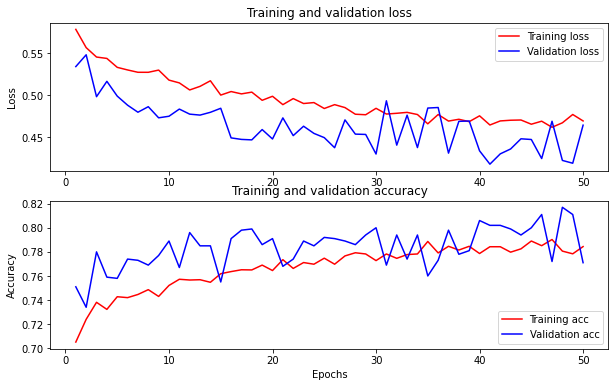

In [60]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')